# Fact Verification and Evidence Retrieval

### Import libraries

In [1]:
import json
import os
import os.path as path
import heapq
import torch
import random

In [2]:
pip install wikipedia

Note: you may need to restart the kernel to use updated packages.


### Define the paths

In [3]:
BASE_DIR = os.getcwd()

raw_training_set = path.join(BASE_DIR, "fever/train.jsonl")
training_doc_file = path.join(BASE_DIR,"fever/train.wiki7.jsonl")
db_path = path.join(BASE_DIR, "fever/fever.db")

print("Base dir:",BASE_DIR)
print("Raw Training set:",raw_training_set)
print("Training DocRetrieval Output File:",training_doc_file)
print("Database path:",db_path)


Base dir: /Users/debrup/PycharmProjects/ir_project/ir_project
Raw Training set: /Users/debrup/PycharmProjects/ir_project/ir_project/fever/train.jsonl
Training DocRetrieval Output File: /Users/debrup/PycharmProjects/ir_project/ir_project/fever/train.wiki7.jsonl
Database path: /Users/debrup/PycharmProjects/ir_project/ir_project/fever/fever.db


### Check if gpu is available

In [4]:
print(torch.backends.mps.is_available())

True


In [5]:
print(torch.backends.mps.is_built())

True


In [6]:
device = torch.device("mps" if torch.device("mps") else "cpu")
print(device)

mps


### Open the train.jsonl file

In [7]:
class Reader:
    def __init__(self,encoding="utf-8"):
        self.enc = encoding

    def read(self,file):
        with open(file,"r",encoding = self.enc) as f:
            return self.process(f)

    def process(self,f):
        pass

In [8]:
class JSONLineReader(Reader):
    def process(self,fp):
        data = []
        for line in fp.readlines():
            data.append(json.loads(line.strip()))
        return data
    

### Read lines of train.json

In [9]:
processed = dict()
jlr = JSONLineReader()
lines = jlr.read(raw_training_set)

In [10]:
print(type(lines))

<class 'list'>


### Get the claim lines

In [11]:
claim_test_lines = [sub['claim'] for sub in lines]
evidence_test_lines = [ sub['evidence'] for sub in lines]

claim_test_lines = claim_test_lines[0:50]
evidence_test_lines = evidence_test_lines[0:50]

print(claim_test_lines[0:3])
print(evidence_test_lines[0:3])

['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'Roman Atwood is a content creator.', 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.']
[[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7], [92206, 104971, 'Fox_Broadcasting_Company', 0]]], [[[174271, 187498, 'Roman_Atwood', 1]], [[174271, 187499, 'Roman_Atwood', 3]]], [[[255136, 254645, 'History_of_art', 2]]]]


### Install stanza

In [12]:
pip install stanza


Note: you may need to restart the kernel to use updated packages.


### Import stanza and download english model

In [13]:
import stanza
stanza.download('en') # download the English model

/Users/debrup/miniconda3/envs/def/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-12 21:57:26 INFO: Downloading default packages for language: en (English) ...
2023-04-12 21:57:28 INFO: File exists: /Users/debrup/stanza_resources/en/default.zip
2023-04-12 21:57:33 INFO: Finished downloading models and saved to /Users/debrup/stanza_resources.


### Try NER on the claim

### Install spacy

In [14]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


### Try NER using spacy

In [15]:
# import spacy

# nlp = spacy.load("en_core_web_sm")


# docs = list(nlp.pipe(claim_test_lines[0:3]))

# for doc in docs:
#     for ent in doc.ents:
#         print(ent.text, ent.label_)

#### As we can see the NER Models cannot get all the required entities. They can only derive very specific entity objects.

### Install nltk

In [16]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


### Extract all the noun phrases of the claims using constituency tree

In [17]:
import stanza
import wikipedia
from tqdm import tqdm

def preprocess(np):
    page = np.replace('( ', '-LRB-')
    page = page.replace(' )', '-RRB-')
    page = page.replace(' - ', '-')
    page = page.replace(' :', '-COLON-')
    page = page.replace(' ,', ',')
    page = page.replace(" 's", "'s")
    page = page.replace(' ', '_')
    return page
    

claim_train_lines = [ sub['claim'] for sub in lines]

nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency',tokenize_pretokenized=True)
entities=[]  # entities will be a list of size len(train_claims) having list of entities(noun_phrases) as each elem
wiki_pages=[]



for claim in tqdm(claim_test_lines):
        doc = nlp(claim)
        sentence=doc.sentences[0]
        tree = sentence.constituency
        np=[]
        tree.visit_preorder(internal = lambda x: np.append(x.leaf_labels()) if (x.label=="NP" or x.label=="NML") else None)
        noun_phrases = [' '.join(n) for n in np]
        entities.append(noun_phrases)
        #www = wikipedia.search(n)
        #print("LLLL:",len(noun_phrases))
        #print(tree)
            
        #predicted_wiki = [preprocess((wikipedia.search(n))[0]) for n in noun_phrases] 
        predicted_wiki = []
        for n in noun_phrases:
            if not len(wikipedia.search(n)) == 0:
                predicted_wiki.append(preprocess((wikipedia.search(n))[0]))
        wiki_pages.append(predicted_wiki)
        
        ##print(noun_phrases)
        ##print(type(sentence.constituency))

        

2023-04-12 21:57:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-04-12 21:57:44 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-04-12 21:57:44 INFO: Using device: cpu
2023-04-12 21:57:44 INFO: Loading: tokenize
2023-04-12 21:57:44 INFO: Loading: pos
2023-04-12 21:57:44 INFO: Loading: constituency
2023-04-12 21:57:44 INFO: Done loading processors!
100%|███████████████████████████████████████████| 50/50 [05:23<00:00,  6.47s/it]


In [18]:
entities

[['Nikolaj Coster-Waldau', 'the Fox Broadcasting Company.'],
 ['Roman Atwood', 'a content creator.', 'a content'],
 ['History of art',
  'History',
  'art',
  'architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.',
  'architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography',
  'architecture, dance, sculpture, music, painting, poetry literature, theatre,',
  'architecture, dance,',
  'graphic arts.'],
 ['Adrienne Bailon', 'an accountant.'],
 ['System of a Down briefly disbanded in limbo.',
  'System of a Down',
  'System',
  'a Down',
  'limbo.'],
 ['Homeland',
  'an American television spy thriller based on the Israeli television series Prisoners of War.',
  'an American television spy thriller',
  'television spy',
  'the Israeli television series Prisoners of War.',
  'the Israeli television series',
  'Prisoners of War.',
  'Prisoners',
  'War.'],
 ['Beautiful', '

In [19]:
len(entities)

50

### DEBUG TO FIND EMPTY SUBLIST

In [20]:
c=0
for sublist in entities:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [21]:
c=0
for sublist in wiki_pages:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [22]:
c=0
for sublist in claim_test_lines:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [23]:
entities[44]

['Nice & Slow', 'a jazz single.']

In [24]:
wiki_pages[44]

['Nice_&_Slow', 'Jazz']

In [25]:
len(wiki_pages)

50

In [26]:
# for claim in tqdm(claim_test_lines[859:1000]):
    
#         doc = nlp(claim)
#         sentence=doc.sentences[0]
#         tree = sentence.constituency
#         np=[]
#         tree.visit_preorder(internal = lambda x: np.append(x.leaf_labels()) if (x.label=="NP" or x.label=="NML") else None)
#         noun_phrases = [' '.join(n) for n in np]
#         entities.append(noun_phrases)
#         #www = wikipedia.search(n)
#         #print("LLLL:",len(noun_phrases))
#         #print(tree)
            
#         #predicted_wiki = [preprocess((wikipedia.search(n))[0]) for n in noun_phrases] 
#         predicted_wiki = []
#         for n in noun_phrases:
#             if not len(wikipedia.search(n)) == 0:
#                 predicted_wiki.append(preprocess((wikipedia.search(n))[0]))
#         wiki_pages.append(predicted_wiki)
        
#         ##print(noun_phrases)
#         ##print(type(sentence.constituency))

In [27]:
len(wiki_pages)

50

### Example noun phrases

In [28]:
print(entities)

[['Nikolaj Coster-Waldau', 'the Fox Broadcasting Company.'], ['Roman Atwood', 'a content creator.', 'a content'], ['History of art', 'History', 'art', 'architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.', 'architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography', 'architecture, dance, sculpture, music, painting, poetry literature, theatre,', 'architecture, dance,', 'graphic arts.'], ['Adrienne Bailon', 'an accountant.'], ['System of a Down briefly disbanded in limbo.', 'System of a Down', 'System', 'a Down', 'limbo.'], ['Homeland', 'an American television spy thriller based on the Israeli television series Prisoners of War.', 'an American television spy thriller', 'television spy', 'the Israeli television series Prisoners of War.', 'the Israeli television series', 'Prisoners of War.', 'Prisoners', 'War.'], ['Beautiful', 'number two', 'the Billboard Hot 100', '2003.

### Example predicted wiki pages

In [29]:
wiki_pages

[['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company'],
 ['Roman_Atwood', 'Content_creation', 'Free_content'],
 ['History_of_art',
  'History',
  'Art',
  'Arts_in_the_Philippines',
  'Non-narrative_film',
  'Arts_in_the_Philippines',
  'Architecture',
  'Graphic_arts'],
 ['Adrienne_Bailon-Houghton', 'Accountant'],
 ['SilverHawks', 'System_of_a_Down', 'System', 'System_of_a_Down', 'Limbo'],
 ['Homeland',
  'List_of_conspiracy-thriller_films_and_television_series',
  'Spy_fiction',
  'Television_Spy',
  'Prisoners_of_War_(TV_series)',
  'Euphoria_(Israeli_TV_series)',
  'Prisoner_of_war',
  'Prisoner',
  'War'],
 ['Beautiful', 'Number_Two', 'Billboard_Hot_100', '2003'],
 ['Neal_Schon', '1954'],
 ['Boston_Celtics', 'TD_Garden', 'Milwaukee_Brewers', 'TD_Garden'],
 ['Ten_Commandments', 'Epic_film'],
 ['Tetris',
  'List_of_best-selling_albums_of_the_21st_century',
  'Millions',
  'List_of_best-selling_singles'],
 ['Cyndi_Lauper',
  'Grammy_Award_for_Best_New_Artist',
  'Grammy_Award_for_Bes

### Example code for retrieving from fever.db

In [30]:
P=preprocess('List_of_The_Simpsons_guest_stars_(seasons 21–present)')

In [31]:
import sqlite3

# Open a connection to the database file
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Execute a SELECT query on the database
query = f"SELECT lines FROM documents where id='Game_of_Thrones'"
cursor.execute(query)

# Retrieve the results of the query
results = cursor.fetchone()

# Print the results
for row in results:
    print(row)

# Close the connection to the database
conn.close()

0	Game of Thrones is an American fantasy drama television series created by David Benioff and D. B. Weiss .	David Benioff	David Benioff	D. B. Weiss	D. B. Weiss	fantasy	fantasy	drama	Drama (film and television)
1	It is an adaptation of A Song of Ice and Fire , George R. R. Martin 's series of fantasy novels , the first of which is A Game of Thrones .	A Song of Ice and Fire	A Song of Ice and Fire	George R. R. Martin	George R. R. Martin	fantasy	fantasy	A Game of Thrones	A Game of Thrones
2	It is filmed at Titanic Studios in Belfast , on location in the United Kingdom , and in Canada , Croatia , Iceland , Malta , Morocco , Spain , and the United States .	Belfast	Belfast
3	The series premiered on HBO in the United States on April 17 , 2011 , and its sixth season ended on June 26 , 2016 .	HBO	HBO
4	The series was renewed for a seventh season , which is scheduled to premiere on July 16 , 2017 , and will conclude with its eighth season in 2018 .
5	
6	
7	Set on the fictional continents of Weste

### Get the names of titles and the lines of pages in fever.db that matches with wiki_pages

In [32]:
import sqlite3

# Open a connection to the database file
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

candidate_lines = []  ## list of size (no_claims), each element of list should be lines of each matched page

count=0

for claim_pages in wiki_pages:
    
    
    for page in claim_pages:
        
        #print("page:",page)
        #Execute a SELECT query on the database
        query = "SELECT lines FROM documents WHERE id=?"
        cursor.execute(query, (page,))

        #print("query:",query)
       
        # Retrieve the results of the query
        results = cursor.fetchone()
        
        #print(results)
        
       # If results are empty continue
        if results is None or len(results) == 0:
            continue  
            
       # Split the string into a list of lines using the newline character
        lines_page = results[0].split('\n')   
        #print(lines_page)
        
        for line in lines_page:
            
         
           # remove tab characters
           line = line.replace('\t', ' ')
           
           while len(line) >= 1 and line[0].isdigit():
                try:
                    line = line[1:]
                    
                except:
                    line=''
                    break
                
           # remove digits
           #line = line.translate(str.maketrans('', '', '0123456789'))
            

           # remove all words after last . (the links to other pages)
           last_period_index = line.rfind(".")

           # Remove everything after the last period
           
           if last_period_index != -1:
               
                line = line[:last_period_index+1]
                   
           
        
           #line = line.split('.')[0]
    
           # remove extra spaces
           line = ' '.join(line.split())
            
           # Each of the elements of candidate lines is a dictionary with (title,lines_page) (K,V) pairs
           
         
           try:
            
              ((candidate_lines[count])[page]).append(line)
                    
           except:
              
              if len(candidate_lines)==count:
                 candidate_lines.append({})
                    
               
                 
            
              try:
                      ((candidate_lines[count])[page]).append(line)
              except:
                      ((candidate_lines[count])[page])=[]
                      ((candidate_lines[count])[page]).append(line)  
                    
        
        
        
    count=count+1


print(candidate_lines[0])

# Close the connection to the database
conn.close()


{'Nikolaj_Coster-Waldau': ['Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .', 'He graduated from Danish National School of Theatre in Copenhagen in 1993 .', "Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- .", 'Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .', '', '', 'In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon .', 'He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .', 'He became widely known to a broad audience for his current role

In [33]:
print(len(candidate_lines))

50


### DEBUG

In [34]:
c=0
for sublist in candidate_lines:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [35]:
import sqlite3

# Open a connection to the database file
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Define the SQL query with a placeholder for the id parameter
query = "SELECT lines FROM documents WHERE id=?"

# Execute the query with the id parameter passed as a tuple
id = "Robert_J._O'Neill"
cursor.execute(query, (id,))

# Fetch the results and print the first row
results = cursor.fetchone()
print(results[0])

0	Robert John O'Neill , -LRB- born 5 November 1936 -RRB- is an Australian historian and academic .
1	He is Chair of the International Academic Advisory Committee at the United States Studies Centre at the University of Sydney , was director of the International Institute for Strategic Studies , based in London , from 1982 to 1987 , and Chichele Professor of the History of War at the University of Oxford from 1987 to 2000 .	University of Oxford	University of Oxford	International Institute for Strategic Studies	International Institute for Strategic Studies	United States Studies Centre	United States Studies Centre	University of Sydney	University of Sydney	Chichele Professor of the History of War	Chichele Professor of the History of War
2	


In [36]:
print(candidate_lines[1])


{'Roman_Atwood': ['Roman Bernard Atwood -LRB- born May 28 , 1983 -RRB- is an American YouTube personality , comedian , vlogger and pranker .', 'He is best known for his vlogs , where he posts updates about his life on a daily basis .', "His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers .", "He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .", 'His prank videos have gained over 1.4 billion views and 10.3 million subscribers .', 'Both of these channels are in the top 100 most subscribed on YouTube , and he became the second YouTuber after Germán Garmendia to receive two Diamond Play Buttons for his two channels .', ''], 'Content_creation': ['Content Creation is the contribution of information to any media and most especially to digital media for an end-user/audience in specific contexts .', "Content is `` something that is to be expressed through some medium , as speech , writing or any of var

In [37]:
## Get the retrieved documents for each claim

retrieved_docs = []
for i in candidate_lines:
    retrieved_docs.append(list(i.keys()))
        

In [38]:
len(retrieved_docs)

50

In [39]:
print(retrieved_docs)

[['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company'], ['Roman_Atwood', 'Content_creation', 'Free_content'], ['History_of_art', 'History', 'Art', 'Non-narrative_film', 'Architecture', 'Graphic_arts'], ['Accountant'], ['SilverHawks', 'System_of_a_Down', 'System', 'Limbo'], ['Homeland', 'List_of_conspiracy-thriller_films_and_television_series', 'Spy_fiction', 'Television_Spy', 'Prisoner_of_war', 'Prisoner', 'War'], ['Beautiful', 'Number_Two', 'Billboard_Hot_100', '2003'], ['Neal_Schon', '1954'], ['Boston_Celtics', 'TD_Garden', 'Milwaukee_Brewers'], ['Ten_Commandments', 'Epic_film'], ['Tetris', 'Millions', 'List_of_best-selling_singles'], ['Cyndi_Lauper', 'Grammy_Award_for_Best_New_Artist', '27th_Annual_Grammy_Awards', '1985'], ['There', 'A_Movie', 'The_Hunger_Games'], ['Ryan_Gosling', 'List_of_African_countries_by_population', 'Country', 'Africa'], ['Stranger_Things', 'Bloomington'], ['Ryan_Seacrest', 'Person'], ['Puerto_Rico', 'Territories_of_the_United_States', 'List_of_states_and_ter

In [40]:
### Find list of ground truth documents
evidence_test_lines[0]

ground_truth_docs=[]
for i in range(len(evidence_test_lines)):
    l1 = evidence_test_lines[i]
    ground_truth_docs.append([])
    for j in range(len(l1)):
        for l2 in evidence_test_lines[i][j]:
             ground_truth_docs[i].append(l2[2])
                
                
    

In [41]:
len(ground_truth_docs)

50

In [42]:
# Find document retrieval accuracy

total_docs=0
correct_docs=0
for i in range(len(ground_truth_docs)):
    
    claim_docs=ground_truth_docs[i]
    for doc in claim_docs:
        total_docs=total_docs+1
        print(doc)
        if doc in ground_truth_docs[i]:
            correct_docs=correct_docs+1
    

Nikolaj_Coster-Waldau
Fox_Broadcasting_Company
Roman_Atwood
Roman_Atwood
History_of_art
Adrienne_Bailon
None
Homeland_-LRB-TV_series-RRB-
Prisoners_of_War_-LRB-TV_series-RRB-
None
None
Boston_Celtics
Boston_Celtics
The_Ten_Commandments_-LRB-1956_film-RRB-
The_Ten_Commandments_-LRB-1956_film-RRB-
Tetris
Cyndi_Lauper
The_Hunger_Games_-LRB-film-RRB-
The_Hunger_Games_-LRB-film-RRB-
The_Hunger_Games_-LRB-film-RRB-
The_Hunger_Games_-LRB-film-RRB-
Ryan_Gosling
Chad
Stranger_Things
Ryan_Seacrest
Ryan_Seacrest
Ryan_Seacrest
Ryan_Seacrest
Puerto_Rico
Michael_Giacchino
Stranger_than_Fiction_-LRB-2006_film-RRB-
Chris_Hemsworth
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
Selena
None
Robert_J._O'Neill_-LRB-U.S._Navy_SEAL-RRB-
None
None
The_Silence_of_the_Lambs_-LRB-film-RRB-
The_Silence_of_the_Lambs_-LRB-film-RRB-
Peggy_Sue_Got_Married
Francis_Ford_Coppola
Peggy_Sue_Got_Married
Andy_Roddick
Bed-In
Tupac_Shakur
Tupac_Shakur
None
The_Jim_Hen

In [43]:
# Find document retrieval accuracy

total_docs=0
correct_docs=0
for i in range(len(ground_truth_docs)):
    
    ground_truth_doc=ground_truth_docs[i]
    total_docs=total_docs+1
    
    if ground_truth_doc==[None]:
        correct_docs=correct_docs+1 
        #print("Here ",i)
        continue
        
    flag=1
    
    #print("GG", retrieved_docs[i])
    #print(ground_truth_doc)
    for doc in ground_truth_doc:
        if doc not in retrieved_docs[i]:
            flag=0
            #print("HERE", i)
            break
            
    if flag==1:
        correct_docs=correct_docs+1 
    
   
       
            
            


In [44]:
ground_truth_docs

[['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company'],
 ['Roman_Atwood', 'Roman_Atwood'],
 ['History_of_art'],
 ['Adrienne_Bailon'],
 [None],
 ['Homeland_-LRB-TV_series-RRB-', 'Prisoners_of_War_-LRB-TV_series-RRB-'],
 [None],
 [None],
 ['Boston_Celtics', 'Boston_Celtics'],
 ['The_Ten_Commandments_-LRB-1956_film-RRB-',
  'The_Ten_Commandments_-LRB-1956_film-RRB-'],
 ['Tetris'],
 ['Cyndi_Lauper'],
 ['The_Hunger_Games_-LRB-film-RRB-',
  'The_Hunger_Games_-LRB-film-RRB-',
  'The_Hunger_Games_-LRB-film-RRB-',
  'The_Hunger_Games_-LRB-film-RRB-'],
 ['Ryan_Gosling', 'Chad'],
 ['Stranger_Things'],
 ['Ryan_Seacrest', 'Ryan_Seacrest', 'Ryan_Seacrest', 'Ryan_Seacrest'],
 ['Puerto_Rico'],
 ['Michael_Giacchino'],
 ['Stranger_than_Fiction_-LRB-2006_film-RRB-'],
 ['Chris_Hemsworth'],
 ['Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena',
  'Selena'],
 [None],
 ["Robert_J._O'Ne

In [45]:
total_docs=0
correct_docs=0

# Accuracy of document retrieval for each claim 
# Correct if the entire ground truth for a claim  is a subset of the retrieved document list for a claim
for i in range(len(ground_truth_docs)):
    doc = ground_truth_docs[i]
    total_docs=total_docs+1
    
    if len(doc) == 1 and doc[0] is None:
        print("YES")
        correct_docs=correct_docs+1
        print("a", retrieved_docs[i])
        print("b", doc)
        
    elif set(doc).issubset(set(retrieved_docs[i])):
        print("YES")
        correct_docs=correct_docs+1
        print("a", retrieved_docs[i])
        print("b", doc)
    else:
        print("NO")
        print("a", retrieved_docs[i])
        print("b", doc)
    print()

YES
a ['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company']
b ['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company']

YES
a ['Roman_Atwood', 'Content_creation', 'Free_content']
b ['Roman_Atwood', 'Roman_Atwood']

YES
a ['History_of_art', 'History', 'Art', 'Non-narrative_film', 'Architecture', 'Graphic_arts']
b ['History_of_art']

NO
a ['Accountant']
b ['Adrienne_Bailon']

YES
a ['SilverHawks', 'System_of_a_Down', 'System', 'Limbo']
b [None]

NO
a ['Homeland', 'List_of_conspiracy-thriller_films_and_television_series', 'Spy_fiction', 'Television_Spy', 'Prisoner_of_war', 'Prisoner', 'War']
b ['Homeland_-LRB-TV_series-RRB-', 'Prisoners_of_War_-LRB-TV_series-RRB-']

YES
a ['Beautiful', 'Number_Two', 'Billboard_Hot_100', '2003']
b [None]

YES
a ['Neal_Schon', '1954']
b [None]

YES
a ['Boston_Celtics', 'TD_Garden', 'Milwaukee_Brewers']
b ['Boston_Celtics', 'Boston_Celtics']

NO
a ['Ten_Commandments', 'Epic_film']
b ['The_Ten_Commandments_-LRB-1956_film-RRB-', 'The_Ten_Commandments_-LRB-1956_fi

In [46]:
total_docs

50

In [47]:
correct_docs

33

In [48]:
accuracy = correct_docs/total_docs
print("Accuracy of document retrieval",accuracy*100,"%")

Accuracy of document retrieval 66.0 %


In [49]:
ground_truth_docs[0]

['Nikolaj_Coster-Waldau', 'Fox_Broadcasting_Company']

In [50]:
print(len(ground_truth_docs))

50


In [51]:
evidence_test_lines[0][0]

[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
 [92206, 104971, 'Fox_Broadcasting_Company', 0]]

In [52]:
print(candidate_lines[1]['Roman_Atwood'][1])

He is best known for his vlogs , where he posts updates about his life on a daily basis .


In [53]:
import wikipedia

# Query text
query = "List_of_The_Simpsons_guest_stars_(seasons 21–present)"

# Search for matching page titles
results = wikipedia.search(query)

# Print the list of matching page titles
print("Matching page titles:")
for title in results:
    print(title)

# Choose a page to retrieve
page_title = results[0]

# Retrieve the content of the page
page = wikipedia.page(page_title)

# Print the page summary and content
print("Page summary:", page.summary)
##print("Page content:", page.content)


Matching page titles:
List of The Simpsons guest stars (seasons 21–present)
List of The Simpsons episodes (season 21–present)
List of The Simpsons episodes
The Simpsons (season 34)
Rosebud (The Simpsons)
Mona Simpson (The Simpsons)
The Simpsons
List of The Simpsons cast members
Homer at the Bat
List of The Simpsons episodes (seasons 1–20)
Page summary: In addition to the show's regular cast of voice actors, celebrity guest stars have been a staple of The Simpsons, an American animated television sitcom created by Matt Groening for the Fox Broadcasting Company, since its first season. The Simpsons focuses on the eponymous family, which consists of Homer, Marge, Bart, Lisa and Maggie. The family was initially conceived by Groening for a series of animated shorts, which originally aired as a part of The Tracey Ullman Show between 1987 and 1989. The shorts were developed into a half-hour prime time series which began in December 1989. The series' 34th season began on September 25, 2022, an

### Compute Similarity between the Claim and the Candidate Evidences found using TF-IDF

In [54]:
import sqlite3

# Open a connection to the database file
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

query = "SELECT lines FROM documents"
cursor.execute(query)

results = cursor.fetchall()


In [55]:
L = len(results)
documents = []
for i in range(0, 300):
    document = results[i][0]
    
    # remove tab characters
    document = document.replace('\t', ' ')
    
    # remove all words after last . (the links to other pages)
    last_period_index = document.rfind(".")

   # Remove everything after the last period

    if last_period_index != -1:
        document = document[:last_period_index+1]
    
#     while len(document) >= 1 and document[0].isdigit():
#         try:
#             document = document[1:]
                    
#         except:
#             document=''
#             break

    document = ' '.join(document.split())
    
    documents.append(document)
    
print((documents))

['0 A Diffusion limited enzyme is an enzyme which catalyses a reaction so efficiently that the rate limiting step is that of substrate diffusion into the active site , or product diffusion out . enzyme enzyme catalyses catalysis rate limiting step rate limiting step substrate enzyme substrate diffusion diffusion active site active site product product (chemistry) 1 This is also known as kinetic perfection or catalytic perfection . 2 Since the rate of catalysis of such enzymes is set by the diffusion-controlled reaction , it therefore represents an intrinsic , physical constraint on evolution -LRB- a maximum peak height in the fitness landscape -RRB- . diffusion diffusion diffusion-controlled reaction diffusion-controlled reaction fitness landscape fitness landscape fitness fitness (biology) 3 Diffusion limited perfect enzymes are very rare . 4 Most enzymes catalyse their reactions to a rate that is 1,000-10 ,000 times slower than this limit . 5 This is due to both the chemical limitati

In [56]:
print(len(documents))

300


In [57]:
print(documents[0])

0 A Diffusion limited enzyme is an enzyme which catalyses a reaction so efficiently that the rate limiting step is that of substrate diffusion into the active site , or product diffusion out . enzyme enzyme catalyses catalysis rate limiting step rate limiting step substrate enzyme substrate diffusion diffusion active site active site product product (chemistry) 1 This is also known as kinetic perfection or catalytic perfection . 2 Since the rate of catalysis of such enzymes is set by the diffusion-controlled reaction , it therefore represents an intrinsic , physical constraint on evolution -LRB- a maximum peak height in the fitness landscape -RRB- . diffusion diffusion diffusion-controlled reaction diffusion-controlled reaction fitness landscape fitness landscape fitness fitness (biology) 3 Diffusion limited perfect enzymes are very rare . 4 Most enzymes catalyse their reactions to a rate that is 1,000-10 ,000 times slower than this limit . 5 This is due to both the chemical limitation

### Term frequency and inverse document frequency


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [59]:
print(claim_test_lines)

['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'Roman Atwood is a content creator.', 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.', 'Adrienne Bailon is an accountant.', 'System of a Down briefly disbanded in limbo.', 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.', 'Beautiful reached number two on the Billboard Hot 100 in 2003.', 'Neal Schon was named in 1954.', 'The Boston Celtics play their home games at TD Garden.', 'The Ten Commandments is an epic film.', 'Tetris has sold millions of physical copies.', 'Cyndi Lauper won the Best New Artist award at the 27th Grammy Awards in 1985.', 'There is a movie called The Hunger Games.', 'Ryan Gosling has been to a country in Africa.', 'Stranger Things is set in Bloomington, Indiana.', 'Ryan Seacrest is a person.', 'Puerto Rico is not an unincorporated territory 

In [60]:
print(len(claim_test_lines))

50


### Extract all sentences with relevance scores  as tuples 

In [61]:

vectorizer = TfidfVectorizer()

# Vectorize the claim and evidences
vectors = vectorizer.fit_transform(documents)
# candidate_sentence = candidate_lines[0]

# Candidate_lines[i] -> the collection of candidate lines in an ith claim from all retrieved documents


claim_similarities = []
for i in range(len(claim_test_lines)):
    similarity_scores_list = []
    sim_score = {}
    claim = claim_test_lines[i]
    
    max_similarity_score = 0
    max_candidate_sentence = ""
    
    for key in candidate_lines[i].keys():
        similarity_all_sentences = []
        candidate_list_sentence = candidate_lines[i][key]
        
        for idx in range(len(candidate_list_sentence)) :
            
            candidate_sentence = candidate_list_sentence[idx]
           # Vectorize the new sentences
            new_vectors = vectorizer.transform([claim,candidate_sentence])

           # Calculate cosine similarity between the two new sentences
            similarity_scores = cosine_similarity(new_vectors)
            
            max_similarity_score = max(max_similarity_score, similarity_scores[0][1])
            if(similarity_scores[0][1] == max_similarity_score):
                max_candidate_sentence = candidate_sentence
            
            similarity_scores_list.append((key,idx, candidate_sentence, similarity_scores[0][1]))
        
    claim_similarities.append(similarity_scores_list)
    

In [62]:
claim_similarities

[[('Nikolaj_Coster-Waldau',
   0,
   'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .',
   0.0),
  ('Nikolaj_Coster-Waldau',
   1,
   'He graduated from Danish National School of Theatre in Copenhagen in 1993 .',
   0.0),
  ('Nikolaj_Coster-Waldau',
   2,
   "Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- .",
   0.011077045314012754),
  ('Nikolaj_Coster-Waldau',
   3,
   'Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .',
   0.0),
  ('Nikolaj_Coster-Waldau', 4, '', 0.0),
  ('Nikolaj_Coster-Waldau', 5, '', 0.0),
  ('Nikolaj_Coster-Waldau',
   6,
   'In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon .',
   0.0137

In [63]:
print(len(claim_similarities))

50


In [64]:
print(claim_similarities[0])

[('Nikolaj_Coster-Waldau', 0, 'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .', 0.0), ('Nikolaj_Coster-Waldau', 1, 'He graduated from Danish National School of Theatre in Copenhagen in 1993 .', 0.0), ('Nikolaj_Coster-Waldau', 2, "Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- .", 0.011077045314012754), ('Nikolaj_Coster-Waldau', 3, 'Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .', 0.0), ('Nikolaj_Coster-Waldau', 4, '', 0.0), ('Nikolaj_Coster-Waldau', 5, '', 0.0), ('Nikolaj_Coster-Waldau', 6, 'In the United States , his debut film role was in the war film Black Hawk Down -LRB- 2001 -RRB- , playing Medal of Honor recipient Gary Gordon .', 0.013796039570337789), ('Nikolaj_Coster-Waldau', 7, 'He then pla

### Extract top K evidence sentences for every claim

In [65]:
# my_list = [(1, 2, 3, 4), (5, 6, 7, 8), (9, 10, 11, 2), (13, 14, 15, 8), (17, 18, 19, 1)]

def topK(my_list, K):
    # Find the indices of the top K tuples in the list based on the 4th element
    top_indices = heapq.nlargest(K, range(len(my_list)), key=lambda i: my_list[i][3])

    # Find the tuples corresponding to the top K indices
    top_tuples = [my_list[i] for i in top_indices]

    # Print the top indices and tuples
    
    zipped_list = list(zip(top_indices, top_tuples))
    
    return zipped_list

In [66]:
K=5
topK_evidences_for_each_claim = []
for i in range(len(claim_similarities)):
    topK_evidences_for_each_claim.append(topK(claim_similarities[i], K))
    

In [67]:
topK_evidences_for_each_claim
# 
# Inner tuple:
# 

# 1st index: position in the claim_no

#     inner tuple:
#         1st element: retrieved document name 
#         2nd: index of the candidate sentence in the retrieved document
#         3rd: candidate sentence
#         4th: Similarity score


[[(11,
   ('Fox_Broadcasting_Company',
    0,
    'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .',
    0.5758582655765112)),
  (24,
   ('Fox_Broadcasting_Company',
    13,
    "The network is named after sister company 20th Century Fox , and indirectly for producer William Fox , who founded one of the movie studio 's predecessors , Fox Film .",
    0.431671434636541)),
  (12,
   ('Fox_Broadcasting_Company',
    1,
    'The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles , with additional major offices and production facilities at the Fox Television Center in nearby West Los Angeles and the Fox Broadcasting Center in the Yorkville neighborhood of Manhattan , New York City .',
    0.35663708520257514)),
  (7,
   ('Nikolaj_Coster-Wa

In [68]:
print(len(topK_evidences_for_each_claim))

50


In [69]:
print((topK_evidences_for_each_claim)[0][0][1][0])  #i j 1 0
print((topK_evidences_for_each_claim)[0][0][1][1])  #i j 1 1

Fox_Broadcasting_Company
0


In [70]:
print((topK_evidences_for_each_claim)[0][0])  #i j 1 0

(11, ('Fox_Broadcasting_Company', 0, 'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', 0.5758582655765112))


In [71]:
retrieved_evidences_tfidf=[]

for i in range(len(topK_evidences_for_each_claim)):
    retrieved_evidences_tfidf.append([])
    t = topK_evidences_for_each_claim[i]
    for j in range(len(t)):
         retrieved_evidences_tfidf[i].append([topK_evidences_for_each_claim[i][j][1][0],topK_evidences_for_each_claim[i][j][1][1]])
        
        
        

In [72]:
len(retrieved_evidences_tfidf)

50

In [73]:
retrieved_evidences_tfidf[0]

[['Fox_Broadcasting_Company', 0],
 ['Fox_Broadcasting_Company', 13],
 ['Fox_Broadcasting_Company', 1],
 ['Nikolaj_Coster-Waldau', 7],
 ['Fox_Broadcasting_Company', 10]]

In [74]:
evidence_test_lines[0]

[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
  [92206, 104971, 'Fox_Broadcasting_Company', 0]]]

In [76]:
claim_test_lines[0]

'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.'

In [77]:
evidence_test_lines[0]

[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
  [92206, 104971, 'Fox_Broadcasting_Company', 0]]]

In [78]:
claim_similarities[0][11]

('Fox_Broadcasting_Company',
 0,
 'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .',
 0.5758582655765112)

In [153]:
retrieved_evidences_tfidf[0]

[['Fox_Broadcasting_Company', 0],
 ['Fox_Broadcasting_Company', 13],
 ['Fox_Broadcasting_Company', 1],
 ['Nikolaj_Coster-Waldau', 7],
 ['Fox_Broadcasting_Company', 10]]

In [160]:
lines[0:10]

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[], []]]},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[]], [[]]]},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.',
  'evidence': [[[]]]},
 {'id': 156709,
  'verifiable': 'VERIFIABLE',
  'label': 'REFUTES',
  'claim': 'Adrienne Bailon is an accountant.',
  'evidence': [[[]]]},
 {'id': 83235,
  'verifiable': 'NOT VERIFIABLE',
  'label': 'NOT ENOUGH INFO',
  'claim': 'System of a Down briefly disbanded in limbo.',
  'evidence': [[[]]]},
 {'id': 129629,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Homeland is an American television spy thrill

In [163]:
evidence_test_lines[0][0]

[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
 [92206, 104971, 'Fox_Broadcasting_Company', 0]]

In [165]:
# ## Evidence retrieval accuracy

evidence_true = []

for i in range(len(evidence_test_lines)):
     evidence_true.append([])
     evidence_sets = evidence_test_lines[i].copy()
     print("rrr",retrieved_evidences_tfidf[i])
     for j in range(len(evidence_sets)):
         evidence_set = evidence_sets[j] 
         print("eee",evidence_set) 
         lll=[]
         for k in range(len(evidence_set)):
            lll.append(evidence_set[k][2:4])
                
                
                
         evidence_true[i].append(lll)   
             
          
                
            
         

rrr [['Fox_Broadcasting_Company', 0], ['Fox_Broadcasting_Company', 13], ['Fox_Broadcasting_Company', 1], ['Nikolaj_Coster-Waldau', 7], ['Fox_Broadcasting_Company', 10]]
eee [[92206, 104971, 'Nikolaj_Coster-Waldau', 7], [92206, 104971, 'Fox_Broadcasting_Company', 0]]
rrr [['Free_content', 0], ['Roman_Atwood', 0], ['Content_creation', 3], ['Content_creation', 0], ['Content_creation', 1]]
eee [[174271, 187498, 'Roman_Atwood', 1]]
eee [[174271, 187499, 'Roman_Atwood', 3]]
rrr [['History_of_art', 2], ['Graphic_arts', 2], ['Art', 6], ['Art', 4], ['History_of_art', 6]]
eee [[255136, 254645, 'History_of_art', 2]]
rrr [['Accountant', 0], ['Accountant', 5], ['Accountant', 1], ['Accountant', 2], ['Accountant', 3]]
eee [[180804, 193183, 'Adrienne_Bailon', 0]]
rrr [['System_of_a_Down', 0], ['System_of_a_Down', 9], ['System_of_a_Down', 7], ['System_of_a_Down', 16], ['System', 0]]
eee [[100277, None, None, None]]
rrr [['Television_Spy', 0], ['List_of_conspiracy-thriller_films_and_television_series', 

IndexError: list index out of range

In [176]:
evidence_true[4][0]

[[None, None]]

In [174]:
retrieved_evidences_tfidf[4]

[['System_of_a_Down', 0],
 ['System_of_a_Down', 9],
 ['System_of_a_Down', 7],
 ['System_of_a_Down', 16],
 ['System', 0]]

In [182]:
len(evidence_true)

51

In [179]:
total_evd = 0
corr_evd = 0

def is_list_subset(list1, list2):
    for sublist in list1:
        if sublist not in list2:
            return False
    return True


for i in range(len(evidence_true)):
    total_evd = total_evd + 1
    evd_sets = evidence_true[i]
    for j in range(len(evd_sets)):
        evd_set = evd_sets[j]
        print(evd_set)
        
        if len(evd_set) == 1 and evd_set[0][0] is None or evd_set[0][1] is None:
            print("YES")
            corr_evd = corr_evd + 1
            print("a", retrieved_evidences_tfidf[i])
            print("b", evd_set)
            break

        elif is_list_subset(evd_set,retrieved_evidences_tfidf[i]):
            print("YES")
            corr_evd = corr_evd + 1
            print("a", retrieved_evidences_tfidf[i])
            print("b", evd_set)
            break
        else:
            print("NO")
            print("a", retrieved_evidences_tfidf[i])
            print("b", evd_set)
        print()

[['Nikolaj_Coster-Waldau', 7], ['Fox_Broadcasting_Company', 0]]
YES
a [['Fox_Broadcasting_Company', 0], ['Fox_Broadcasting_Company', 13], ['Fox_Broadcasting_Company', 1], ['Nikolaj_Coster-Waldau', 7], ['Fox_Broadcasting_Company', 10]]
b [['Nikolaj_Coster-Waldau', 7], ['Fox_Broadcasting_Company', 0]]
[['Roman_Atwood', 1]]
NO
a [['Free_content', 0], ['Roman_Atwood', 0], ['Content_creation', 3], ['Content_creation', 0], ['Content_creation', 1]]
b [['Roman_Atwood', 1]]

[['Roman_Atwood', 3]]
NO
a [['Free_content', 0], ['Roman_Atwood', 0], ['Content_creation', 3], ['Content_creation', 0], ['Content_creation', 1]]
b [['Roman_Atwood', 3]]

[['History_of_art', 2]]
YES
a [['History_of_art', 2], ['Graphic_arts', 2], ['Art', 6], ['Art', 4], ['History_of_art', 6]]
b [['History_of_art', 2]]
[['Adrienne_Bailon', 0]]
NO
a [['Accountant', 0], ['Accountant', 5], ['Accountant', 1], ['Accountant', 2], ['Accountant', 3]]
b [['Adrienne_Bailon', 0]]

[[None, None]]
YES
a [['System_of_a_Down', 0], ['System_o

In [180]:
total_evd

51

In [181]:
corr_evd

31

### Find relevance of each candidate evidence sentence using BERT-based models(training)

### Install transformers

In [79]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


### Import required libraries

In [80]:
import torch
import random
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split

# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Load pre-trained BERT model and tokenizer


In [81]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

### This is a sequence classification task with two labels (Relevant or not)
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


### Get (claim,evidence,label) pairs

In [82]:
print(len(evidence_test_lines))

50


In [83]:
print(evidence_test_lines[0])

[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7], [92206, 104971, 'Fox_Broadcasting_Company', 0]]]


In [84]:
print(evidence_test_lines)

[[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7], [92206, 104971, 'Fox_Broadcasting_Company', 0]]], [[[174271, 187498, 'Roman_Atwood', 1]], [[174271, 187499, 'Roman_Atwood', 3]]], [[[255136, 254645, 'History_of_art', 2]]], [[[180804, 193183, 'Adrienne_Bailon', 0]]], [[[100277, None, None, None]]], [[[151831, 166598, 'Homeland_-LRB-TV_series-RRB-', 0], [151831, 166598, 'Prisoners_of_War_-LRB-TV_series-RRB-', 0]]], [[[173384, None, None, None]]], [[[273626, None, None, None]]], [[[49158, 58489, 'Boston_Celtics', 3]], [[49159, 58490, 'Boston_Celtics', 3]]], [[[23513, 28977, 'The_Ten_Commandments_-LRB-1956_film-RRB-', 0]], [[23513, 28978, 'The_Ten_Commandments_-LRB-1956_film-RRB-', 20]]], [[[269479, 265800, 'Tetris', 18]]], [[[56492, 66697, 'Cyndi_Lauper', 2]]], [[[93100, 106004, 'The_Hunger_Games_-LRB-film-RRB-', 0]], [[93100, 106005, 'The_Hunger_Games_-LRB-film-RRB-', 1]], [[93100, 106006, 'The_Hunger_Games_-LRB-film-RRB-', 2]], [[93100, 106007, 'The_Hunger_Games_-LRB-film-RRB-', 16]]], [[

In [85]:
import sqlite3

# Open a connection to the database file
conn = sqlite3.connect(db_path)

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

claims_to_train_on = [ sub['claim'] for sub in lines]
claims_to_train_on =claims_to_train_on[0:50]        # We take 50 claims to get examples

claim_label_pos = []
candidate_evidence_pos = []
claim_pos = []

for i in range(len(claims_to_train_on)):    # For all the claims
    
    for j in range(len(evidence_test_lines[i][0])):
        
            page = evidence_test_lines[i][0][j][2]
            
            #Check if page is NONE (can happen in not enough info claim case)
            if (page==None):  # For None type page (for not enough info)
                continue
            

            line_no = evidence_test_lines[i][0][j][3]
            
           
            # Execute a SELECT query on the database
            query = "SELECT lines FROM documents WHERE id=?"
            cursor.execute(query, (page,))
            
            # Retrieve the results of the query
            results = cursor.fetchone()
                
            lines_page = results[0].split('\n') 
            line = lines_page[line_no]
            line = line.replace('\t', ' ')
            
            while len(line) >= 1 and line[0].isdigit():
                try:
                    line = line[1:]
                    
                except:
                    line=''
                    break
                
      
            # remove all words after last . (the links to other pages)
            last_period_index = line.rfind(".")
            
            # Remove everything after the last period
            if last_period_index != -1:
                line = line[:last_period_index+1]
                   
           
            # remove extra spaces
            line = ' '.join(line.split())
            
            claim_pos.append(claims_to_train_on[i])
            candidate_evidence_pos.append(line)
            claim_label_pos.append(1)
            
                
            
# Close the connection to the database
conn.close()

In [86]:
claim_label_pos

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [87]:
candidate_evidence_pos

['He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .',
 'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .',
 'He is best known for his vlogs , where he posts updates about his life on a daily basis .',
 'The subsequent expansion of the list of principal arts in the 20th century reached to nine : architecture , dance , sculpture , music , painting , poetry -LRB- described broadly as a form of literature with aesthetic purpose or function , which also includes the distinct genres of theatre and narrative -RRB- , film , photography and graphic arts .',
 'Adrienne Eliza Houghton -LRB- née Bailon ; born October 24 , 1983 -RRB- is an Ame

In [88]:
claim_pos

['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
 'Roman Atwood is a content creator.',
 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.',
 'Adrienne Bailon is an accountant.',
 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.',
 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.',
 'The Boston Celtics play their home games at TD Garden.',
 'The Ten Commandments is an epic film.',
 'Tetris has sold millions of physical copies.',
 'Cyndi Lauper won the Best New Artist award at the 27th Grammy Awards in 1985.',
 'There is a movie called The Hunger Games.',
 'Ryan Gosling has been to a country in Africa.',
 'Ryan Gosling has been to a country in Africa.',
 'Stranger Things is set in Bloomington

In [89]:
len(claim_pos)

44

In [90]:
len(claim_label_pos)

44

In [91]:
len(candidate_evidence_pos)

44

In [92]:
c=0
for sublist in claim_pos:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [93]:
c=0
for sublist in claim_label_pos:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [94]:
c=0
for sublist in candidate_evidence_pos:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

### Negative samples

In [95]:
print(len(claims_to_train_on))

50


In [96]:
no_of_neg = 1
k=10

claim_neg = []
candidate_neg = []
label_neg =[]

import re

def check_digit(s):
    # remove any extra spaces or tabs from the string
    s = s.strip()
    # define a regular expression pattern to match 2-digit numbers
    pattern = r'^\d{1,2}$'
    # use the re.match() function to check if the string matches the pattern
    match = re.match(pattern, s)
    # if the match object is not None, then the string is a 2-digit number
    if match:
        return True
    else:
        return False



for i in range(len(claims_to_train_on)):
    claim = claims_to_train_on[i]
    # Look at pages related to claim
    random_pages = wikipedia.search(claim)
    #print("AAAAAAAAA........",random_pages)
        
    n = len(random_pages)
    #print("value of n",n)
        
    # Check if n=0 then continue(no search result for the claim)
    if(n==0):
       continue
            
    for j in range(no_of_neg):
        
        # Pick a random page from the list
        page_name = random_pages[random.randint(0, n-1)]
        
        
        
        #print("BBBBBBB",page_name)
       
        
        conn = sqlite3.connect(db_path)

        # Create a cursor object to execute SQL commands
        cursor = conn.cursor()

        page_name=preprocess(page_name)
        
        # Execute a SELECT query on the database
        query = "SELECT lines FROM documents WHERE id=?"
        cursor.execute(query, (page_name,))
        
        
        # Retrieve the results of the query
        results = cursor.fetchone()
        
        #print("CCCCCCC",results)
        
        # If results are empty continue
        if results is None or len(results) == 0:
            continue  
            
        # Split the string into a list of lines using the newline character
        lines_page = results[0].split('\n') 
        #lines_page = lines_page[0:k]
        #print(type(lines_page))
        
        # Get a random line from first k lines
        flag = True

        # simulate a do-while loop
       
         
        # sample random line
        line = lines_page[random.randrange(len(lines_page))]

        # preprocess the line
        line = line.replace('\t', ' ')

        while len(line) >= 1 and line[0].isdigit():
            try:
                line = line[1:]

            except:
                line=''
                break



        # remove all words after last . (the links to other pages)
        last_period_index = line.rfind(".")

        # Remove everything after the last period

        if last_period_index != -1:
            line = line[:last_period_index+1]

        # remove extra spaces
        line = ' '.join(line.split())

        if len(line)==0:
           continue 

        
        #print((claim,line,0))                             
        claim_neg.append(claim)
        candidate_neg.append(line)
        label_neg.append(0)

In [97]:
print(len(claim_neg))

24


In [98]:
print(len(candidate_neg))

24


In [99]:
print(len(label_neg))

24


In [100]:
print(claim_neg[1])
print(candidate_neg[1])
print(label_neg[1])

Roman Atwood is a content creator.
Both of these channels are in the top 100 most subscribed on YouTube , and he became the second YouTuber after Germán Garmendia to receive two Diamond Play Buttons for his two channels .
0


In [101]:
c=0
for sublist in claim_neg:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [102]:
c=0
for sublist in candidate_neg:
    if not sublist:
        print("Empty sublist found!")
        print()
        break
    c=c+1   

In [103]:
print(claim_pos[0]) 
print(candidate_evidence_pos[0])
print(claim_label_pos[0])


Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam -LRB- 2008 -RRB- , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .
1


### Define train_claims,train_evidence and train_labels using positive and negative samples

In [104]:
train_claims = claim_pos + claim_neg
train_evidence = candidate_evidence_pos + candidate_neg
train_labels = claim_label_pos + label_neg


In [105]:
print(train_claims)

['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'Roman Atwood is a content creator.', 'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.', 'Adrienne Bailon is an accountant.', 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.', 'Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.', 'The Boston Celtics play their home games at TD Garden.', 'The Ten Commandments is an epic film.', 'Tetris has sold millions of physical copies.', 'Cyndi Lauper won the Best New Artist award at the 27th Grammy Awards in 1985.', 'There is a movie called The Hunger Games.', 'Ryan Gosling has been to a country in Africa.', 'Ryan Gosling has been to a country in Africa.', 'Stranger Things is set in Bloomington, Indiana.', '

In [106]:
print(len(train_claims))

68


In [107]:
print(len(train_evidence))

68


In [108]:
print(len(train_labels))

68


### Load your training data

In [109]:
# Tokenize input sequences
input_ids = []
attention_masks = []
for claim, evidence in zip(train_claims, train_evidence):
    encoded_dict = tokenizer.encode_plus(
                        claim,
                        evidence,
                        add_special_tokens = True,
                        max_length = 256,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

    


In [110]:
print(len(input_ids))

68


In [111]:
print(input_ids)

[tensor([[  101, 24794,  3501,  3465,  2121,  1011, 24547,  2850,  2226,  2499,
          2007,  1996,  4419,  5062,  2194,  1012,   102,  2002,  2059,  2209,
          6317,  2198,  7598,  1999,  1996,  2460,  1011,  2973,  4419,  2547,
          2186,  2047,  7598,  1011,  1048, 15185,  1011,  2263,  1011, 25269,
          2497,  1011,  1010,  2004,  2092,  2004,  6037,  2004,  3581, 12694,
          1999,  1996,  2268,  4419,  2547,  2143,  7484,  3012,  1010,  2761,
          3832,  2004,  1037,  4405,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0, 

In [112]:
import numpy

In [113]:
print(len(attention_masks))

68


In [114]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

In [115]:
input_ids

tensor([[  101, 24794,  3501,  ...,     0,     0,     0],
        [  101, 24794,  3501,  ...,     0,     0,     0],
        [  101,  3142,  2012,  ...,     0,     0,     0],
        ...,
        [  101,  9893,  5912,  ...,     0,     0,     0],
        [  101,  8861,  2402,  ...,     0,     0,     0],
        [  101, 11944,  1998,  ...,     0,     0,     0]])

In [116]:
input_ids.shape

torch.Size([68, 256])

In [117]:
attention_masks

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [118]:
attention_masks.shape

torch.Size([68, 256])

In [119]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [120]:
labels.shape

torch.Size([68])

### Construct dataset with (input_ids,attention_masks,labels)

In [121]:
# Combine input sequences with labels
dataset = TensorDataset(input_ids, attention_masks, labels)

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [122]:
print(len(train_dataset))
print(len(val_dataset))

54
14


### Construct the dataloaders

In [123]:
# Create data loaders for batching

batch_size = 4
train_dataloader = DataLoader(train_dataset, sampler=torch.utils.data.RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=torch.utils.data.SequentialSampler(val_dataset), batch_size=batch_size)


### Load the pretrained model

In [124]:
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Finetune the pretrained BERT Model using training examples

In [125]:
# Set up the optimizer and loss function
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

n_epochs = 5

model = model.to(device)
model.train()

for epoch in range(n_epochs):
    print('Training epoch %d...' % epoch)
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        #print("AAAAA",outputs[0])
        loss = criterion(outputs[1], labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    print('Average training loss: %.4f' % (total_loss / len(train_dataloader)))

# Evaluate the fine-tuned model on your validation set
# Let's assume your validation set is in the same format as your training set
# and you have converted it into a DataLoader of input tensors called val_dataloader
# with the same structure as train_dataloader
model.eval()
with torch.no_grad():
    val_loss = 0
    val_accuracy = 0
    val_steps = 0
    
    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        
        # Extract loss and logits from the model output
        val_loss += outputs.loss.item()
        logits = outputs.logits

        # Convert logits to probabilities and get predicted labels
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Compute accuracy for the batch
        val_accuracy += torch.sum(preds == labels).item()

        # Update the number of evaluation steps
        val_steps += 1
        
        
# Calculate average evaluation loss and accuracy
avg_val_loss = val_loss / val_steps
avg_val_accuracy = val_accuracy / len(val_dataset)
        


Training epoch 0...
Average training loss: 0.6853
Training epoch 1...
Average training loss: 0.5025
Training epoch 2...
Average training loss: 0.3636
Training epoch 3...
Average training loss: 0.2639
Training epoch 4...
Average training loss: 0.2616


In [126]:
probs.shape

torch.Size([2, 2])

### Print Validation Accuracy

In [127]:
print("avg val accuracy", avg_val_accuracy)
print("avg loss",avg_val_loss)

avg val accuracy 0.6428571428571429
avg loss 0.9971619620919228


In [128]:
## Get the sentences with top relevant scores for every claim 

In [129]:
print(len(candidate_lines))

50


In [130]:
print(len(claim_test_lines))

50


In [132]:
claim_similarities_bert=[]

for i in tqdm(range(len(claim_test_lines))):
    
    similarity_scores_list_bert = []
    sim_score_bert = {}
    claim = claim_test_lines[i]
    
    max_similarity_score_bert = 0
    max_candidate_sentence_bert = ""
    
    for key in candidate_lines[i].keys():
        similarity_all_sentences = []
        candidate_list_sentence = candidate_lines[i][key]
        
        for idx in range(len(candidate_list_sentence)) :
            
            candidate_sentence = candidate_list_sentence[idx]
            
            #Vectorize the new sentences
            #new_vectors = vectorizer.transform([claim,candidate_sentence])

            #Calculate cosine similarity between the two new sentences
            #similarity_scores = cosine_similarity(new_vectors)
            
            ## Tokenizer acts on (claim,sentence)
            encoded_dict = tokenizer.encode_plus(
                        claim,
                        candidate_sentence,
                        add_special_tokens = True,
                        max_length = 256,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
            input_ids = encoded_dict['input_ids'].to(device)
            attention_mask = encoded_dict['attention_mask'].to(device)
            
            #print("Input_ids shape",input_ids.shape)
            #print("Att masks shape",attention_mask.shape)
            
            ## Get the output corresponding to this example
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
            
            probs = F.softmax(outputs.logits, dim=1)
            probs_relevance = probs[0,1]
            
            max_similarity_score_bert = max(max_similarity_score_bert, probs_relevance)
            if(probs_relevance == max_similarity_score_bert):
                max_candidate_sentence_bert = candidate_sentence
            
            similarity_scores_list_bert.append((key,idx, candidate_sentence,probs_relevance))
        
    claim_similarities_bert.append(similarity_scores_list_bert)

100%|███████████████████████████████████████████| 50/50 [03:01<00:00,  3.63s/it]


In [133]:
claim_similarities_bert[0]

/Users/debrup/miniconda3/envs/def/lib/python3.11/site-packages/torch/_tensor_str.py:115: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  nonzero_finite_vals = torch.masked_select(


[('Nikolaj_Coster-Waldau',
  0,
  'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .',
  tensor(0.9165, device='mps:0')),
 ('Nikolaj_Coster-Waldau',
  1,
  'He graduated from Danish National School of Theatre in Copenhagen in 1993 .',
  tensor(0.0927, device='mps:0')),
 ('Nikolaj_Coster-Waldau',
  2,
  "Coster-Waldau 's breakthrough performance in Denmark was his role in the film Nightwatch -LRB- 1994 -RRB- .",
  tensor(0.1546, device='mps:0')),
 ('Nikolaj_Coster-Waldau',
  3,
  'Since then he has appeared in numerous films in his native Scandinavia and Europe in general , including Headhunters -LRB- 2011 -RRB- and A Thousand Times Good Night -LRB- 2013 -RRB- .',
  tensor(0.1348, device='mps:0')),
 ('Nikolaj_Coster-Waldau', 4, '', tensor(0.0849, device='mps:0')),
 ('Nikolaj_Coster-Waldau', 5, '', tensor(0.0849, device='mps:0')),
 ('Nikolaj_Coster-Waldau',
  6,
  'In the United States , his debut

In [134]:
claim_similarities_bert[1]

[('Roman_Atwood',
  0,
  'Roman Bernard Atwood -LRB- born May 28 , 1983 -RRB- is an American YouTube personality , comedian , vlogger and pranker .',
  tensor(0.9138, device='mps:0')),
 ('Roman_Atwood',
  1,
  'He is best known for his vlogs , where he posts updates about his life on a daily basis .',
  tensor(0.9202, device='mps:0')),
 ('Roman_Atwood',
  2,
  "His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers .",
  tensor(0.1742, device='mps:0')),
 ('Roman_Atwood',
  3,
  "He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .",
  tensor(0.0870, device='mps:0')),
 ('Roman_Atwood',
  4,
  'His prank videos have gained over 1.4 billion views and 10.3 million subscribers .',
  tensor(0.3890, device='mps:0')),
 ('Roman_Atwood',
  5,
  'Both of these channels are in the top 100 most subscribed on YouTube , and he became the second YouTuber after Germán Garmendia to receive two Diamond Play Buttons f

In [135]:
K

5

In [136]:
## Get the top k corresponding to each claim(Same as tf-idf)

topK_evidences_for_each_claim_bert = []
for i in range(len(claim_similarities_bert)):
    topK_evidences_for_each_claim_bert.append(topK(claim_similarities_bert[i], K))
    

In [137]:
topK_evidences_for_each_claim_bert[0]

[(11,
  ('Fox_Broadcasting_Company',
   0,
   'The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .',
   tensor(0.9442, device='mps:0'))),
 (0,
  ('Nikolaj_Coster-Waldau',
   0,
   'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .',
   tensor(0.9165, device='mps:0'))),
 (16,
  ('Fox_Broadcasting_Company',
   5,
   'Launched on October 9 , 1986 as a competitor to the Big Three television networks -LRB- ABC , NBC and CBS -RRB- , Fox went on to become the most successful attempt at a fourth television network .',
   tensor(0.8700, device='mps:0'))),
 (12,
  ('Fox_Broadcasting_Company',
   1,
   'The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles ,

In [138]:
## Save the bert model used for evidence retrieval

# Save the model to a file
model.save_pretrained('model_f/')

# Save the tokenizer to a file
tokenizer.save_pretrained('model_f/')

('model_f/tokenizer_config.json',
 'model_f/special_tokens_map.json',
 'model_f/vocab.txt',
 'model_f/added_tokens.json')

In [139]:
# Load the saved model from a file
model_load = BertForSequenceClassification.from_pretrained('model_f/')

# Load the saved tokenizer from a file
tokenizer_load = BertTokenizer.from_pretrained('model_f/')


In [140]:
model_load

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [141]:
tokenizer_load

BertTokenizer(name_or_path='model_f/', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [143]:
label_train_lines = [ sub['label'] for sub in lines]

In [144]:
label_train_lines = label_train_lines[0:50]

In [145]:
print(label_train_lines)

['SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO', 'SUPPORTS', 'NOT ENOUGH INFO', 'NOT ENOUGH INFO', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'NOT ENOUGH INFO', 'SUPPORTS', 'NOT ENOUGH INFO', 'NOT ENOUGH INFO', 'SUPPORTS', 'REFUTES', 'REFUTES', 'REFUTES', 'SUPPORTS', 'NOT ENOUGH INFO', 'SUPPORTS', 'NOT ENOUGH INFO', 'NOT ENOUGH INFO', 'SUPPORTS', 'SUPPORTS', 'NOT ENOUGH INFO', 'NOT ENOUGH INFO', 'SUPPORTS', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'NOT ENOUGH INFO', 'SUPPORTS', 'REFUTES', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS']


In [146]:
# Get list of dictionaries 

retrieved_evidence=[]

for i in range(len(claim_test_lines)):
    retrieved_evidence.append({})
    
    (retrieved_evidence[i])['claim']=claim_test_lines[i]
    (retrieved_evidence[i])['evidence']=[]
    ret_evidence =topK_evidences_for_each_claim_bert[i]
    (retrieved_evidence[i])['label']= label_train_lines[i]
    for j in range(len(ret_evidence)):
        (retrieved_evidence[i])['evidence'].append(ret_evidence[j][1][2])
        
    
print(retrieved_evidence)    
    

[{'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'evidence': ['The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', 'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .', 'Launched on October 9 , 1986 as a competitor to the Big Three television networks -LRB- ABC , NBC and CBS -RRB- , Fox went on to become the most successful attempt at a fourth television network .', 'The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles , with additional major offices and production facilities at the Fox Television Center in nearby West Los Angeles and the Fox Broadcasting Center in the Yorkville neighborhood of Manhattan , New York C

In [147]:
# Get list of dictionaries 

retrieved_evidence_new=[]

for i in range(len(claim_test_lines)):
    retrieved_evidence_new.append({})
    
    (retrieved_evidence_new[i])['claim']=claim_test_lines[i]
    (retrieved_evidence_new[i])['evidence']=[]
    ret_evidence =topK_evidences_for_each_claim_bert[i]
    (retrieved_evidence_new[i])['label']= label_train_lines[i]
    
    for j in range(len(ret_evidence)):
        (retrieved_evidence_new[i])['evidence'].append(ret_evidence[j][1][2])
        
    
    separator = "|"
    joint_evidence = separator.join(item for item in (retrieved_evidence_new[i])['evidence'])
    (retrieved_evidence_new[i])['string_evidence']=joint_evidence
        
        
        
    
print(retrieved_evidence_new)    
    

[{'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'evidence': ['The Fox Broadcasting Company -LRB- often shortened to Fox and stylized as FOX -RRB- is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .', 'Nikolaj Coster-Waldau -LRB- -LSB- neɡ̊olaɪ̯ kʰʌsd̥ɐ ˈʋald̥ɑʊ̯ -RSB- ; born 27 July 1970 -RRB- is a Danish actor , producer and screenwriter .', 'Launched on October 9 , 1986 as a competitor to the Big Three television networks -LRB- ABC , NBC and CBS -RRB- , Fox went on to become the most successful attempt at a fourth television network .', 'The network is headquartered at the 20th Century Fox studio lot on Pico Boulevard in the Century City section of Los Angeles , with additional major offices and production facilities at the Fox Television Center in nearby West Los Angeles and the Fox Broadcasting Center in the Yorkville neighborhood of Manhattan , New York C

In [148]:
## Make CSV file with columns claim,evidence,label

import csv

# Example list of dictionaries

# Open a CSV file for writing
with open('retrieved_evidence_output1.csv', 'w', newline='') as csvfile:
    
    # Define the fieldnames for the CSV file
    fieldnames = ['claim', 'evidence', 'label','string_evidence']
    
    # Create a writer object and write the fieldnames to the CSV file
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    # Write each row of data to the CSV file
    for row in retrieved_evidence_new:
        writer.writerow(row)


In [149]:
retrieved_evidences_bert=[]

for i in range(len(topK_evidences_for_each_claim_bert)):
    retrieved_evidences_bert.append([])
    t = topK_evidences_for_each_claim_bert[i]
    for j in range(len(t)):
         retrieved_evidences_bert[i].append([topK_evidences_for_each_claim_bert[i][j][1][0],topK_evidences_for_each_claim_bert[i][j][1][1]])
        
        

In [150]:
retrieved_evidences_bert[0]

[['Fox_Broadcasting_Company', 0],
 ['Nikolaj_Coster-Waldau', 0],
 ['Fox_Broadcasting_Company', 5],
 ['Fox_Broadcasting_Company', 1],
 ['Fox_Broadcasting_Company', 10]]

/var/folders/dt/nr1bpqhj02nczn6h6wf73x1c0000gn/T/ipykernel_10234/3793191445.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


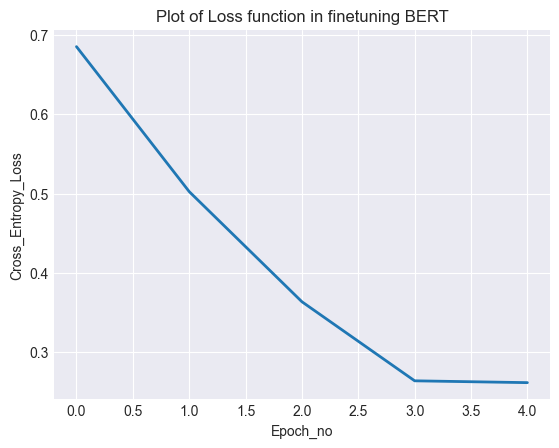

In [152]:
import matplotlib.pyplot as plt

# Set the plot style
plt.style.use('seaborn-darkgrid')

# Define the data
loss_epochs = [0.6853,0.5025,0.3636,0.2639,0.2616]

# Create the plot
plt.plot(loss_epochs, linewidth=2)
plt.xlabel('Epoch_no')
plt.ylabel('Cross_Entropy_Loss')
plt.title('Plot of Loss function in finetuning BERT')
plt.grid(True)
plt.show()

